## Contents

* [Introduction](#Introduction)
    * [Imports](#Imports)
    * [About the RAVDESS dataset](#About_the_RAVDESS_dataset)
    * [About the CREMA-D dataset](#About_the_CREMA-D_dataset)
* [Loading the datasets](#Loading_the_datasets)
    * [Correlation](#Correlation)
* [Exploring features with models](#Exploring_features_with_models)
    * [Random Forest Classifier](#Random_Forest_Classifier)
        * [Random Forest with RAVDESS](#Random_Forest_with_RAVDESS)
    * [Gradient Boosting](#Gradient_Boosting)
        * [Gradient Boosting with RAVDESS](#Gradient_Boosting_with_RAVDESS)
        * [Light Gradient Boosting Machine RAVDESS](#Light_Gradient_Boosting_Machine_RAVDESS)
* [Conclusion](#Conclusion)

# Introduction

In these next sections I will be using various methods and functions to help determine which features are
helping identify the emotions the most. I start with the RAVDESS dataset and Random Forest. The output will help
point us in the right direction for feature importance.

## Imports

In [1]:
# Importing libraries necessary to perform analysis
import librosa
import librosa.display
import soundfile
import pandas as pd
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lightgbm as lgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import mpl_toolkits.mplot3d

from dotenv import load_dotenv, find_dotenv

import warnings

# Suppress specific warnings related to certain modules
warnings.filterwarnings('ignore', module='seaborn')
warnings.filterwarnings('ignore', module='pandas')
warnings.filterwarnings('ignore', module='lightgbm')

load_dotenv()
sound_path = os.getenv('audio_path')

## About the RAVDESS dataset<a id='About_the_RAVDESS_dataset'></a>

This dataset is pulled from the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). It has 
classifications that are contained in the file names. They are as follows:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

Academic citation

If you use the RAVDESS in an academic publication, please use the following citation: Livingstone SR, Russo FA (2018) 
    The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and 
        vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

All other attributions

If you use the RAVDESS in a form other than an academic publication, such as in a blog post, school project, or 
non-commercial product, please use the following attribution: "The Ryerson Audio-Visual Database of Emotional Speech 
    and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

### Some changes

After various testing, I decided to move forward with only the RAVDESS dataset. TESS had great performance but 
only consisted of 2 voice actresses and did not cover the masculine nature of speech. CREMA-D was larger than 
RAVDESS but due to it's varied nature of nationalities and accents, it seemed best to start with the middle ground. 
There may be some evidence below of these 2 datasets but they will not be used for final testing.

# Loading the datasets<a id='Loading_the_datasets'></a>

*[Contents](#Contents)

# Exploring features with models<a id='Exploring_features_with_models'></a>

## Random Forest Classifier<a id='Random_Forest_Classifier'></a>

*[Contents](#Contents)

In [2]:
data1 = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
# data2 = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
# data3 = pd.read_csv('voice_data_dw_t.csv')     # CREMA-D data
df = pd.DataFrame(data1)
# df_c = pd.DataFrame(data2)
# df_t = pd.DataFrame(data3)
pd.set_option('display.max_columns', None)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_max,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-16.392443,202.98502,-645.92170,-7.125899,82.844154,0.365277,0.181984,3.290076,36.87685,-15.079271,0.568462,8.395280,1.881931,2.384150,-2.929066,16.196424,-35.155490,-0.093855,9.038805,-1.890271,2.538881,0.607089,0.141472,1.0,0.600354,0.236534,0.086949,-0.952044,0.007324,1.707622,1.860741e-18,0.000056,0.045920,3.904024,16.927513,24.848774,81.737506,4.558243,18.060076,19.179764,-0.332873,0.920353,2862.926393,7495.930442,1162.137023,2306.370804,1505.855829,1.652513,1.915730,5278.790509,11923.828125,1998.046875,4651.367188,2714.027774,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-16.195488,193.51984,-644.16350,-6.892159,83.358950,0.258790,-0.088001,3.281766,36.88804,-14.507144,0.626492,8.581219,1.857355,2.298338,-3.001566,15.750255,-34.858368,-0.140539,9.143971,-1.889248,2.497091,0.565118,0.135088,1.0,0.526963,0.247438,0.231975,-0.966832,0.008445,1.459130,1.702563e-18,0.000053,0.052460,3.737249,15.052235,25.445381,81.394861,5.744724,18.907480,19.201790,0.101690,2.415374,2856.267937,7574.012464,1196.255587,2532.671446,1438.028687,1.745676,2.597192,5509.765625,11837.890625,2041.015625,5156.250000,2578.736315,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-15.760641,209.64243,-599.33685,-6.811954,80.973440,0.349635,-0.079561,3.183938,33.61964,-16.218931,0.521331,8.188260,1.812531,2.258523,-2.733035,16.290403,-33.561646,-0.003302,8.798903,-1.845969,2.446758,0.566147,0.085513,1.0,0.543228,0.236025,0.195621,-0.746908,0.011151,1.726585,2.294504e-18,0.000077,0.065326,3.784763,16.238434,25.271402,84.231012,3.335950,18.387247,19.357776,-0.364876,1.243544,3147.076638,9735.443474,1074.722832,2347.152059,2109.463110,1.894945,2.580431,5705.295139,12525.390625,1890.625000,5059.570312,3023.452212,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-16.046278,215.37698,-620.35815,-7.427359,81.609146,0.240670,-0.124088,3.185494,34.72454,-14.316382,0.496043,8.297734,1.826856,2.279578,-2.840508,17.101452,-35.499820,-0.068866,8.946567,-1.873974,2.477692,0.605738,0.112530,1.0,0.586911,0.229687,0.158463,-0.645343,0.010260,1.904755,2.764673e-18,0.000067,0.061361,3.518846,13.859685,25.348465,82.521337,4.348983,19.184102,19.175904,-0.306959,0.998655,3128.884756,9390.101251,1315.933093,2504.069840,2070.285142,1.732141,1.991167,5710.712139,12482.421875,1847.656250,5134.765625,3071.179190,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-16.582544,205.08063,-692.11237,-

### Random Forest with RAVDESS<a id='Random_Forest_with_RAVDESS'></a>

*[Contents](#Contents)

In [23]:
# function to help convert emotion labels for readability
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [45]:
# saving feature options for later use
# feature_male = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta_median', 'mfcc_delta2_mean', 'mfcc_delta2_min', 
#                 'chroma_mean', 'mel_mean', 'mel_median', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 
#                 'rms_mean', 'zero_cr_mean']
# feature_female = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                   'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                   'rms_mean', 'zero_cr_mean']

In [25]:
# defining feature list
feature_list = df.columns[8:]

In [26]:
# Dividing dataset into genders
df_male = df[df['actor_gender'] == 1]
df_female = df[df['actor_gender'] == 2]

# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

# Features and labels for male dataset
X_male = df_male[feature_male].values
y_male = df_male['emotion'].values

# Features and labels for female dataset
X_female = df_female[feature_female].values
y_female = df_female['emotion'].values

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.25, random_state=42, shuffle=True, stratify=y_male)

# Splitting the female dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.25, random_state=42, shuffle=True, stratify=y_female)

# Initialize scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_m_sc = scaler_male.fit_transform(X_train_male)
X_test_m_sc = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_f_sc = scaler_female.fit_transform(X_train_female)
X_test_f_sc = scaler_female.transform(X_test_female)

print("Male Dataset:", X_train_m_sc.shape, X_test_m_sc.shape, y_train_male.shape, y_test_male.shape)
print("Female Dataset:", X_train_f_sc.shape, X_test_f_sc.shape, y_train_female.shape, y_test_female.shape)

Male Dataset: (504, 69) (168, 69) (504,) (168,)
Female Dataset: (504, 69) (168, 69) (504,) (168,)


In [27]:
# Training male dataset
# best accuracy result: 0.6011904761904762
# model_male = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_features=69, max_depth=15, 
#                                     min_samples_leaf=5, min_weight_fraction_leaf=0.0, min_samples_split=5, 
#                                     random_state=42, n_jobs=-1, warm_start=True)

model_male = RandomForestClassifier(criterion='entropy', max_depth=15, max_features=69, min_samples_leaf=5, 
                                    min_samples_split=5, n_estimators=1000, n_jobs=-1, random_state=42, warm_start=True, 
                                    min_weight_fraction_leaf=0.0)

model_male.fit(X_train_m_sc, y_train_male)

RandomForestClassifier(max_features=20, min_samples_leaf=15, n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [28]:
# Training female dataset
# best accuracy result: 0.5833333333333334
# model_female = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_features=69, max_depth=15, 
#                                     min_samples_leaf=5, min_weight_fraction_leaf=0.0, min_samples_split=5, 
#                                     random_state=42, n_jobs=-1, warm_start=True)

model_female = RandomForestClassifier(criterion='entropy', max_depth=15, max_features=69, min_samples_leaf=5, 
                                    min_samples_split=5, n_estimators=1000, n_jobs=-1, random_state=42, warm_start=True, 
                                    min_weight_fraction_leaf=0.0)

model_female.fit(X_train_f_sc, y_train_female)

RandomForestClassifier(max_features=20, min_samples_leaf=15, n_estimators=1000,
                       n_jobs=-1, random_state=42)

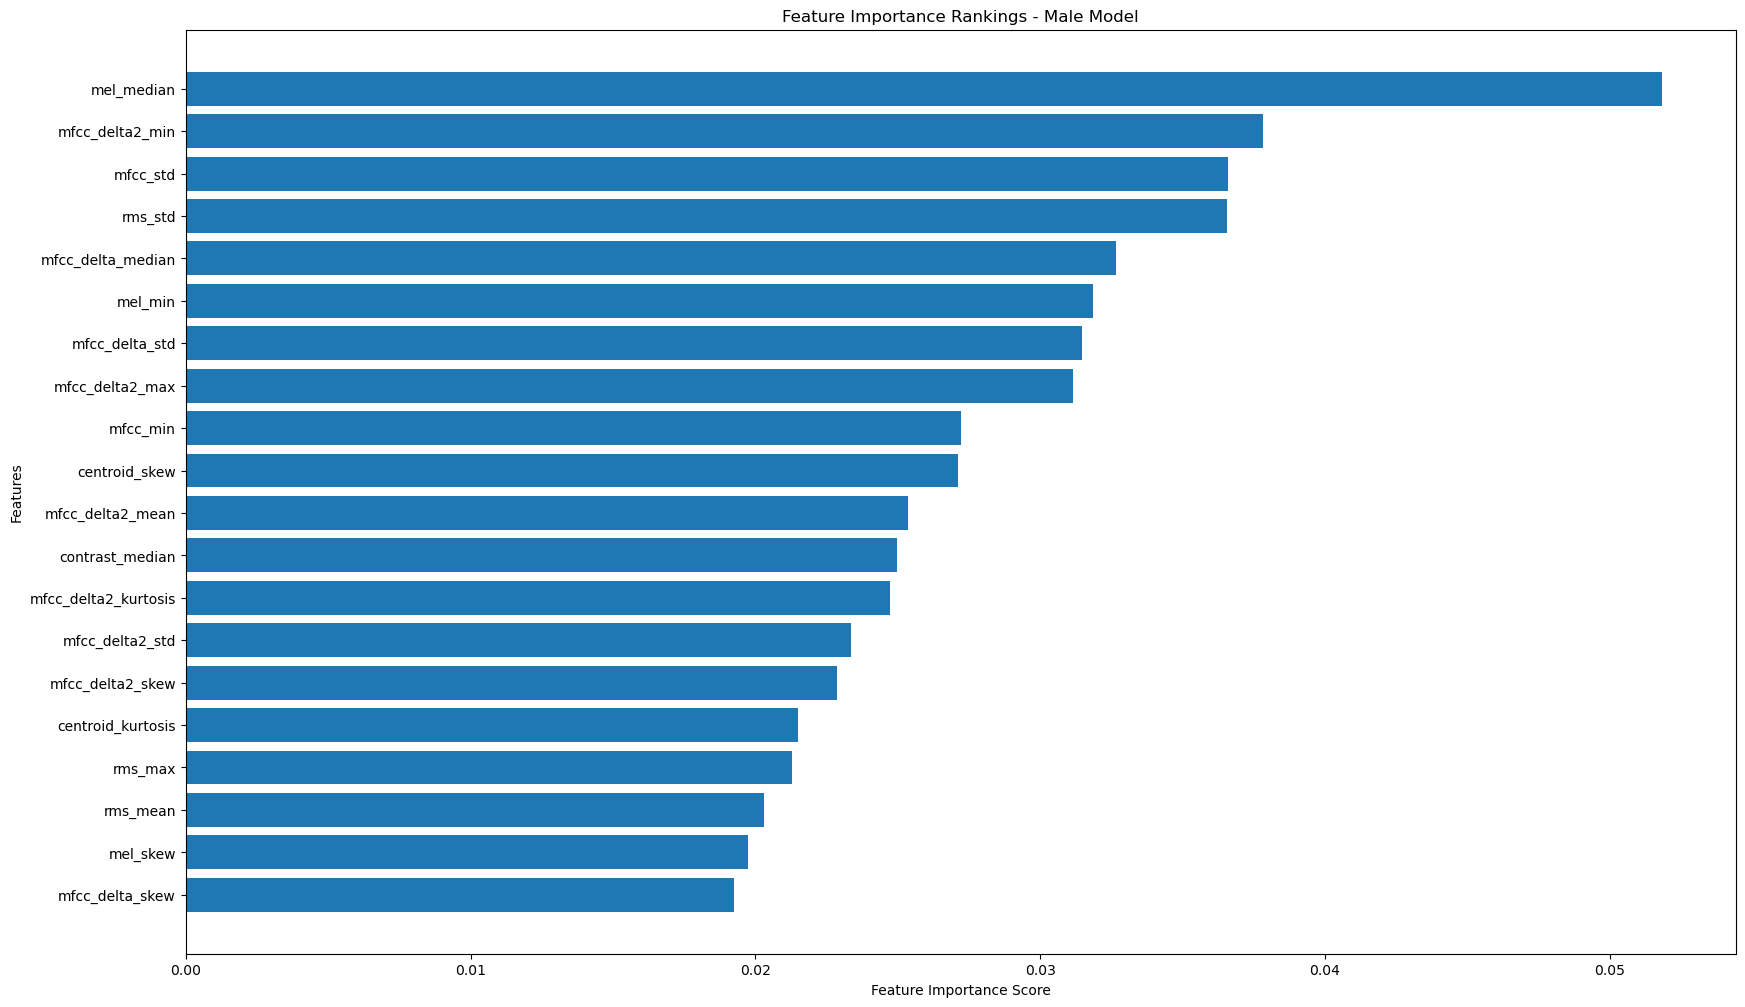

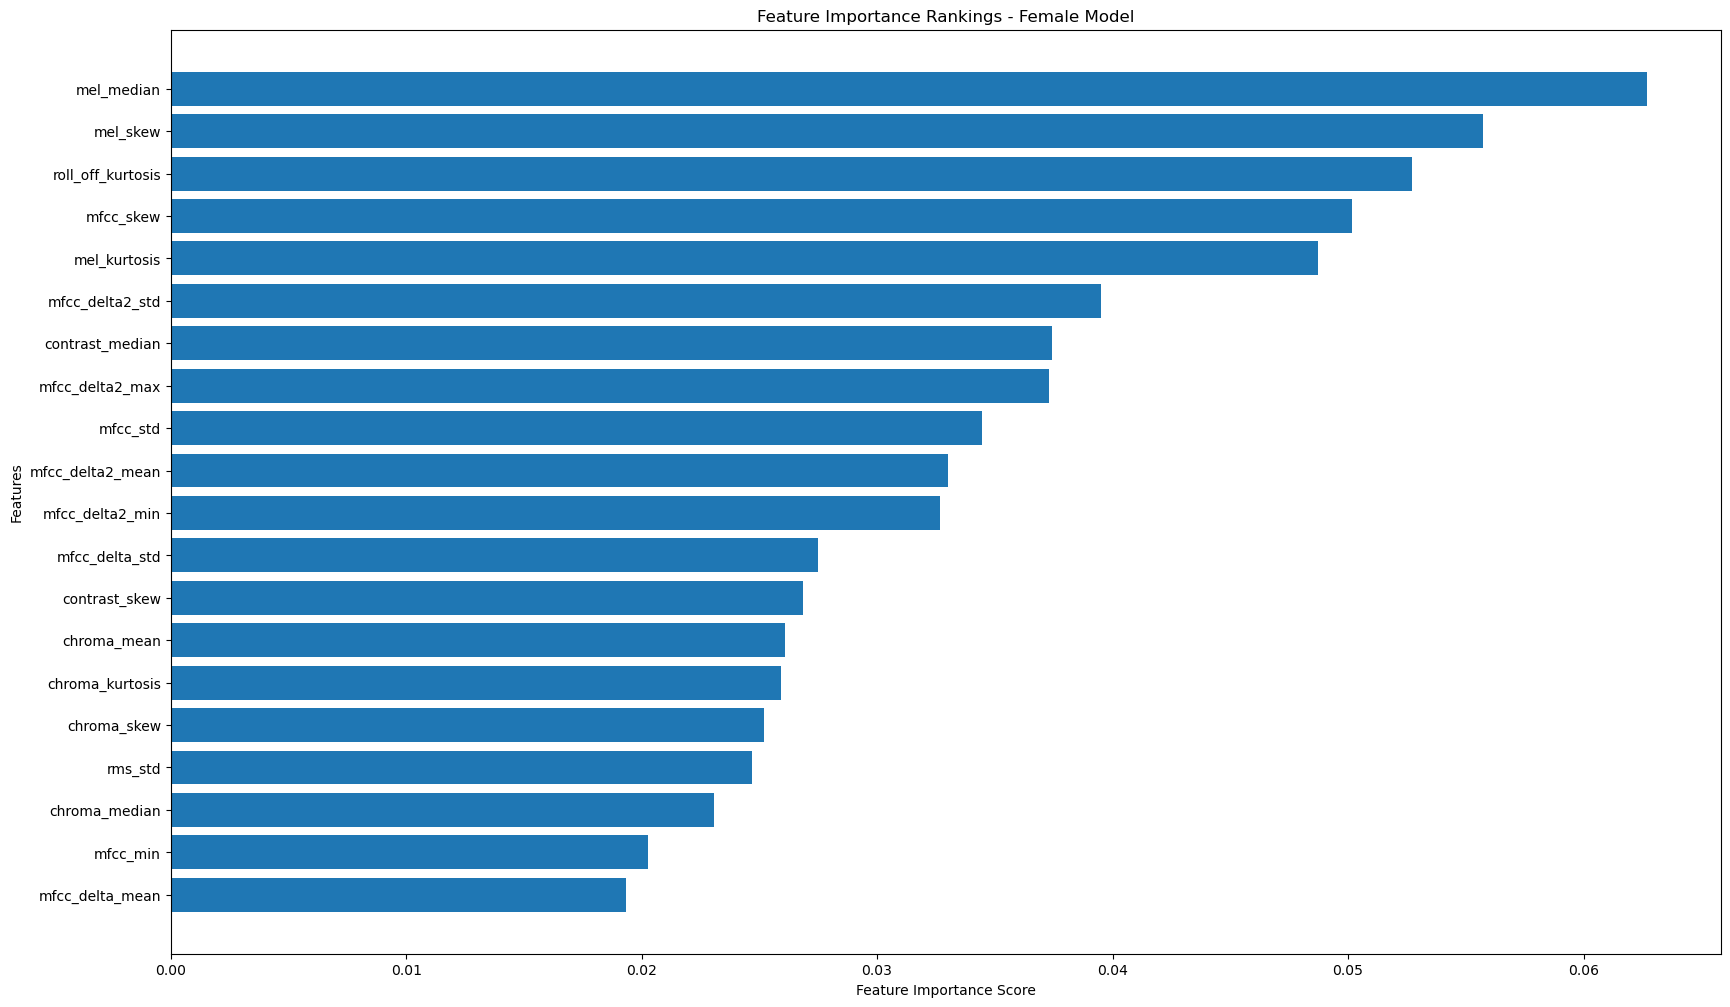

In [29]:
# 'model_male' and 'model_female' are the trained Random Forest models
feature_importances_male = model_male.feature_importances_
feature_importances_female = model_female.feature_importances_

# Update this list to match the features used in your current model
feature_names_m = feature_male
feature_names_f = feature_female

# Creating dictionaries to map feature names to their importances for each model
importances_male = dict(zip(feature_names_m, feature_importances_male))
importances_female = dict(zip(feature_names_f, feature_importances_female))

# Function to plot feature importances and return top 30 features
def plot_feature_importances_and_get_top_30(importances, title):
    # Sort features by importance
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and scores
    sorted_features = [x[0] for x in sorted_importances]
    sorted_scores = [x[1] for x in sorted_importances]

    # Plot
    plt.figure(figsize=(20, 12))
    plt.barh(sorted_features[:30], sorted_scores[:30])  # Plot only top 30 features
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Return top 30 features
    return sorted_features[:30]

# Get and plot top 30 features for male model
top_30_features_male = plot_feature_importances_and_get_top_30(importances_male, 'Feature Importance Rankings - Male Model')

# Get and plot top 20 features for female model
top_30_features_female = plot_feature_importances_and_get_top_30(importances_female, 'Feature Importance Rankings - Female Model')


In [16]:
# Predict on the test set
y_pred_male = model_male.predict(X_test_m_sc)
y_pred_female = model_female.predict(X_test_f_sc)

In [17]:
# Evaluate the models
accuracy_male = accuracy_score(y_test_male, y_pred_male)
accuracy_female = accuracy_score(y_test_female, y_pred_female)

print(confusion_matrix(y_test_male, y_pred_male))
print(classification_report(y_test_male, y_pred_male))
print(f"Accuracy for Male Model: {accuracy_male}")
print()
print()
print(confusion_matrix(y_test_female, y_pred_female))
print(classification_report(y_test_female, y_pred_female))
print(f"Accuracy for Female Model: {accuracy_female}")

Accuracy for Male Model: 0.5476190476190477
              precision    recall  f1-score   support

       angry       0.67      0.75      0.71        24
        calm       0.56      0.92      0.70        24
     disgust       0.69      0.75      0.72        24
     fearful       0.70      0.29      0.41        24
       happy       0.43      0.38      0.40        24
         sad       0.31      0.21      0.25        24
   surprised       0.45      0.54      0.49        24

    accuracy                           0.55       168
   macro avg       0.54      0.55      0.53       168
weighted avg       0.54      0.55      0.53       168

Accuracy for Female Model: 0.47023809523809523
              precision    recall  f1-score   support

       angry       0.52      0.58      0.55        24
        calm       0.61      0.71      0.65        24
     disgust       0.50      0.33      0.40        24
     fearful       0.36      0.42      0.38        24
       happy       0.32      0.29      0.

Random Forrest did not produce great results after testing multiple parameter settings. I will still consider feature 
importance going forward. mel_median, mfcc_delta2_min, mfcc_std, and rms_std seem promising for male voices. 
mel_median, mel_skew, roll_off_kertosis, mfcc_skew, and mel_kurtosis seem like good predictors for female voices.

## Gradient Boosting<a id='Gradient_Boosting'></a>

In [3]:
data1 = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
data2 = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
data3 = pd.read_csv('voice_data_dw_t.csv')     # CREMA-D data
df = pd.DataFrame(data1)
df_c = pd.DataFrame(data2)
df_t = pd.DataFrame(data3)
pd.set_option('display.max_columns', None)
df_c.head()

,filename,statement,emotion,voice_intensity,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_max,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,1001_DFA_ANG_XX.wav,DFA,anger,XX,-7.861806,172.13882,-367.82138,-3.355731,45.420494,-0.083274,-0.317473,1.187952,16.956244,-12.737326,0.423875,3.606701,0.693152,1.005156,-0.981090,13.191930,-17.895924,-0.240981,4.171079,-0.385588,2.576616,0.588556,0.163789,1.0,0.566777,0.228812,0.225032,-0.662147,1.239642,206.462370,2.373865e-16,0.016901,6.900043,3.094822,10.779486,23.797403,79.505578,3.059759,17.288663,20.248185,0.061636,1.998101,3609.426934,7754.493084,1701.402784,3444.230591,1306.044737,1.413663,2.314508,6816.365560,13449.218750,2320.312500,6294.921875,2743.203390,0.863480,0.212954,0.078334,0.191608,0.016036,0.073865,0.048450,0.566373,-0.510565,0.105326,0.266113,0.041504,0.098877,0.046664,1.461352,2.607774
1,1001_DFA_DIS_XX.wav,DFA,disgust,XX,-9.452926,175.35466,-450.32560,-4.190086,53.548960,0.044376,-0.239999,1.546185,23.313921,-13.368842,0.411277,4.464417,1.251220,1.907795,-1.545072,13.445838,-26.327261,-0.118847,5.480439,-1.268124,2.561582,0.676517,0.187586,1.0,0.667416,0.204820,-0.105566,-0.637919,0.162168,21.914064,8.120840e-17,0.004463,0.836368,3.212106,11.721422,22.642638,82.147362,4.400302,15.951105,19.997707,0.022740,1.118758,3751.440501,8007.821995,2112.120462,3545.149524,1279.224074,1.674937,3.033505,6978.685462,13492.187500,3931.640625,5811.523438,2493.686061,1.244088,0.541582,0.028362,0.069885,0.004940,0.023955,0.015989,0.909930,0.185061,0.108738,0.271973,0.043945,0.106201,0.051661,1.394082,2.008864
2,1001_DFA_FEA_XX.wav,DFA,fearful,XX,-7.836610,138.94637,-321.09644,-3.260339,39.805393,-0.009055,-0.480545,1.125755,15.371421,-10.453515,0.433482,3.043510,0.394238,0.593903,-0.697880,10.824774,-15.925366,-0.153619,3.405736,-0.177140,2.267163,0.526264,0.122044,1.0,0.500715,0.247628,0.292454,-0.805667,2.282289,431.301270,6.593233e-16,0.036461,15.092337,2.765274,8.131363,23.860653,79.237179,3.045544,17.236737,19.232741,-0.000300,0.575309,3733.852313,8395.628866,2754.300466,3402.650261,1192.906545,2.441903,5.900998,6712.332589,14072.265625,3716.796875,5693.359375,2592.592934,1.565273,1.892657,0.110559,0.224669,0.014313,0.112171,0.058515,0.059786,-1.035065,0.103251,0.235840,0.040039,0.089355,0.046278,1.585550,1.822081
3,1001_DFA_HAP_XX.wav,DFA,happy,XX,-7.816556,159.30455,-369.91170,-3.084167,43.203660,0.120049,-0.126849,1.072193,18.129837,-11.115734,0.386965,3.254987,0.480288,0.642292,-0.817846,13.787669,-18.676065,-0.073203,3.848503,-0.298762,3.032291,0.609570,0.193454,1.0,0.593258,0.225788,0.175140,-0.797312,1.363221,241.798510,5.656082e-16,0.022572,8.080648,3.070979,9.987621,23.640892,80.958320,3.349195,17.190883,19.833611,-0.256704,0.505664,3581.831080,7748.041609,2192.063396,3333.595630,1115.076039,2.421424,6.498064,6748.416385,13535.156250,4039.062500,5929.687500,2215.827395,1.519381,2.082263,0.083394,0.189180,0.012610,0.077070,0.044943,0.600728,-0.537000,0.094951,0.221680,0.034668,0.086914,0.042843,1.538277,2.198416
4,1001_DFA_NEU_XX.wav,DFA,neutral,XX,-9.037200,176.85399,-421.88104,-3.800208,51.701850,0.062062,-0.284272,1.467234,21.755198,-12.428983,0.40343

### Gradient Boosting with RAVDESS<a id='Gradient_Boosting_with_RAVDESS'></a>

*[Contents](#Contents)

In [2]:
data1 = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
# data2 = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
# data3 = pd.read_csv('voice_data_dw_t.csv')     # CREMA-D data
df = pd.DataFrame(data1)
# df_c = pd.DataFrame(data2)
# df_t = pd.DataFrame(data3)
pd.set_option('display.max_columns', None)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-13.750966,208.77170,-651.9564,-5.260116,82.799590,-0.140461,-0.240087,2.491733,33.705196,-17.369028,0.262886,8.115748,1.653565,2.387000,-3.528996,13.174137,-39.414215,-0.135289,10.488796,-2.105011,2.833700,0.395015,0.010886,0.312053,0.300928,0.685030,-0.547113,0.009552,2.615224,4.031165e-18,0.000064,0.065616,3.980199,17.590267,25.992423,75.029004,6.442893,19.913183,16.481322,-0.583810,1.214911,1431.463197,3747.965221,581.068512,1153.185402,752.927915,1.652513,1.915730,2639.395255,5961.914062,999.023438,2325.683594,1357.013887,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-14.013200,203.44556,-647.6516,-5.660081,83.142610,-0.055090,-0.332986,2.484158,33.476566,-16.323960,0.169552,8.183585,1.682235,2.384677,-3.587220,12.778202,-41.543182,-0.156874,10.659009,-2.112810,2.841899,0.372111,0.007602,0.275195,0.309303,0.783203,-0.390124,0.010960,2.218609,3.065071e-18,0.000057,0.074393,3.737703,14.996470,26.730421,75.095133,5.744724,21.058785,16.718861,-0.121057,2.233361,1428.133969,3787.006232,598.127794,1266.335723,719.014344,1.745676,2.597192,2754.882812,5918.945312,1020.507812,2578.125000,1289.368157,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-13.286643,212.63199,-603.8165,-5.457789,80.696570,-0.069167,-0.244607,2.352925,30.742325,-17.451830,0.207793,7.844898,1.603152,2.356841,-3.394885,11.864449,-39.883760,-0.110547,10.175233,-2.084090,2.802068,0.365138,0.006354,0.270417,0.299614,0.818134,-0.119496,0.015128,2.815824,4.134282e-18,0.000086,0.100440,3.830205,16.569090,26.321257,79.730935,4.494108,20.461424,16.544478,-0.328206,1.317845,1573.538319,4867.721737,537.361416,1173.576030,1054.731555,1.894945,2.580431,2852.647569,6262.695312,945.312500,2529.785156,1511.726106,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-13.380160,214.31924,-625.3130,-5.920652,81.306900,-0.068310,-0.379298,2.378634,32.634373,-17.722158,0.145714,7.996109,1.636472,2.379754,-3.510836,13.831413,-42.689724,-0.203858,10.426331,-2.097874,2.825182,0.399993,0.012884,0.301367,0.299288,0.811549,-0.325152,0.014019,3.281666,4.709254e-18,0.000072,0.097377,3.622848,14.702682,26.110333,78.056904,4.348983,20.056309,16.610803,-0.369971,1.573650,1564.442378,4695.050625,657.966547,1252.034920,1035.142571,1.732141,1.991167,2855.356070,6241.210938,923.828125,2567.382812,1535.589595,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-14.227764,217.13522,-693.7061,-4.584452,90.910904,-0.134584,-0

In [15]:
# function to help convert emotion labels for readability
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [141]:
df.columns

Index(['filename', 'modality', 'vocal_channel', 'emotion', 'voice_intensity',
       'statement', 'statement_repetition', 'actor_gender', 'mfcc_mean',
       'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std', 'mfcc_skew',
       'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max', 'mfcc_delta_min',
       'mfcc_delta_median', 'mfcc_delta_std', 'mfcc_delta_skew',
       'mfcc_delta_kurtosis', 'mfcc_delta2_mean', 'mfcc_delta2_max',
       'mfcc_delta2_min', 'mfcc_delta2_median', 'mfcc_delta2_std',
       'mfcc_delta2_skew', 'mfcc_delta2_kurtosis', 'chroma_mean', 'chroma_min',
       'chroma_max', 'chroma_median', 'chroma_std', 'chroma_skew',
       'chroma_kurtosis', 'mel_mean', 'mel_max', 'mel_min', 'mel_median',
       'mel_std', 'mel_skew', 'mel_kurtosis', 'contrast_mean', 'contrast_max',
       'contrast_min', 'contrast_median', 'contrast_std', 'contrast_skew',
       'contrast_kurtosis', 'centroid_mean', 'centroid_max', 'centroid_min',
       'centroid_median', 'centroid_std', 'cen

In [4]:
# Creating a feature list from the dataset
feature_list = df.columns[8:]

In [5]:
# Dividing dataset into genders
df_male = df[df['actor_gender'] == 1]
df_female = df[df['actor_gender'] == 2]

# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

# Features and labels for male dataset
X_male = df_male[feature_list]
y_male = df_male['emotion'].values

# Features and labels for female dataset
X_female = df_female[feature_list]
y_female = df_female['emotion'].values

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.35, random_state=42, shuffle=True, stratify=y_male)

# Splitting the female dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.35, random_state=42, shuffle=True, stratify=y_female)

# Initialize scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_m_sc = pd.DataFrame(scaler_male.fit_transform(X_train_male), columns=X_train_male.columns)
X_test_m_sc = pd.DataFrame(scaler_male.transform(X_test_male), columns=X_test_male.columns)

# Scale the female datasets
X_train_f_sc = pd.DataFrame(scaler_female.fit_transform(X_train_female), columns=X_train_female.columns)
X_test_f_sc = pd.DataFrame(scaler_female.transform(X_test_female), columns=X_test_female.columns)

print("Male Dataset:", X_train_m_sc.shape, X_test_m_sc.shape, y_train_male.shape, y_test_male.shape)
print("Female Dataset:", X_train_f_sc.shape, X_test_f_sc.shape, y_train_female.shape, y_test_female.shape)

Male Dataset: (436, 69) (236, 69) (436,) (236,)
Female Dataset: (436, 69) (236, 69) (436,) (236,)


In [6]:
# Initialize the Gradient Boosting Classifier and train the model
# saving parameters while adjusting for best performance
# best result: 0.7142857142857143
# gb_clf_male = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
#                                          min_samples_leaf=15, max_features=20, random_state=42)

gb_clf_male = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
                                         min_samples_leaf=15, max_features=20, random_state=42)

gb_clf_male.fit(X_train_m_sc, y_train_male)

GradientBoostingClassifier(max_depth=6, max_features=20, min_samples_leaf=15,
                           min_samples_split=20, n_estimators=500,
                           random_state=42)

In [7]:
# Initialize the Gradient Boosting Classifier and train the model
# saving parameters while adjusting for best performance
# best result: 0.6568
# gb_clf_female = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
#                                            min_samples_leaf=15, max_features=20, random_state=42) 

gb_clf_female = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
                                           min_samples_leaf=15, max_features=20, random_state=42) 

gb_clf_female.fit(X_train_f_sc, y_train_female)

GradientBoostingClassifier(max_depth=6, max_features=20, min_samples_leaf=15,
                           min_samples_split=20, n_estimators=500,
                           random_state=42)

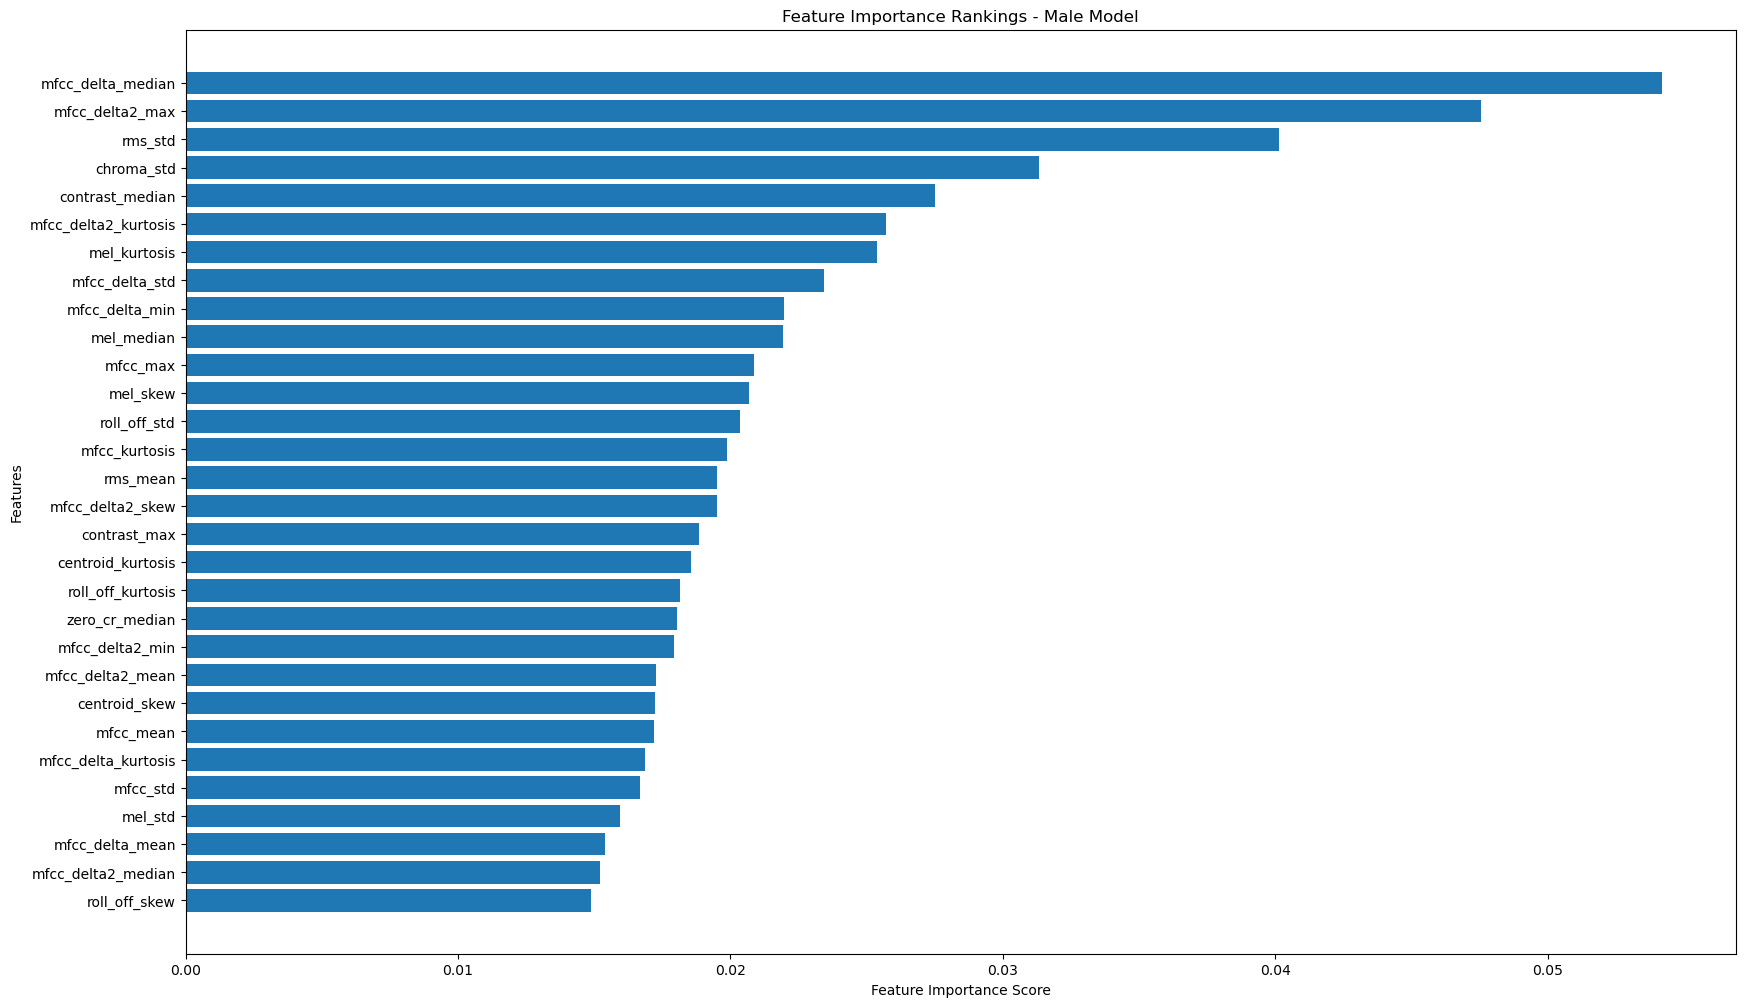

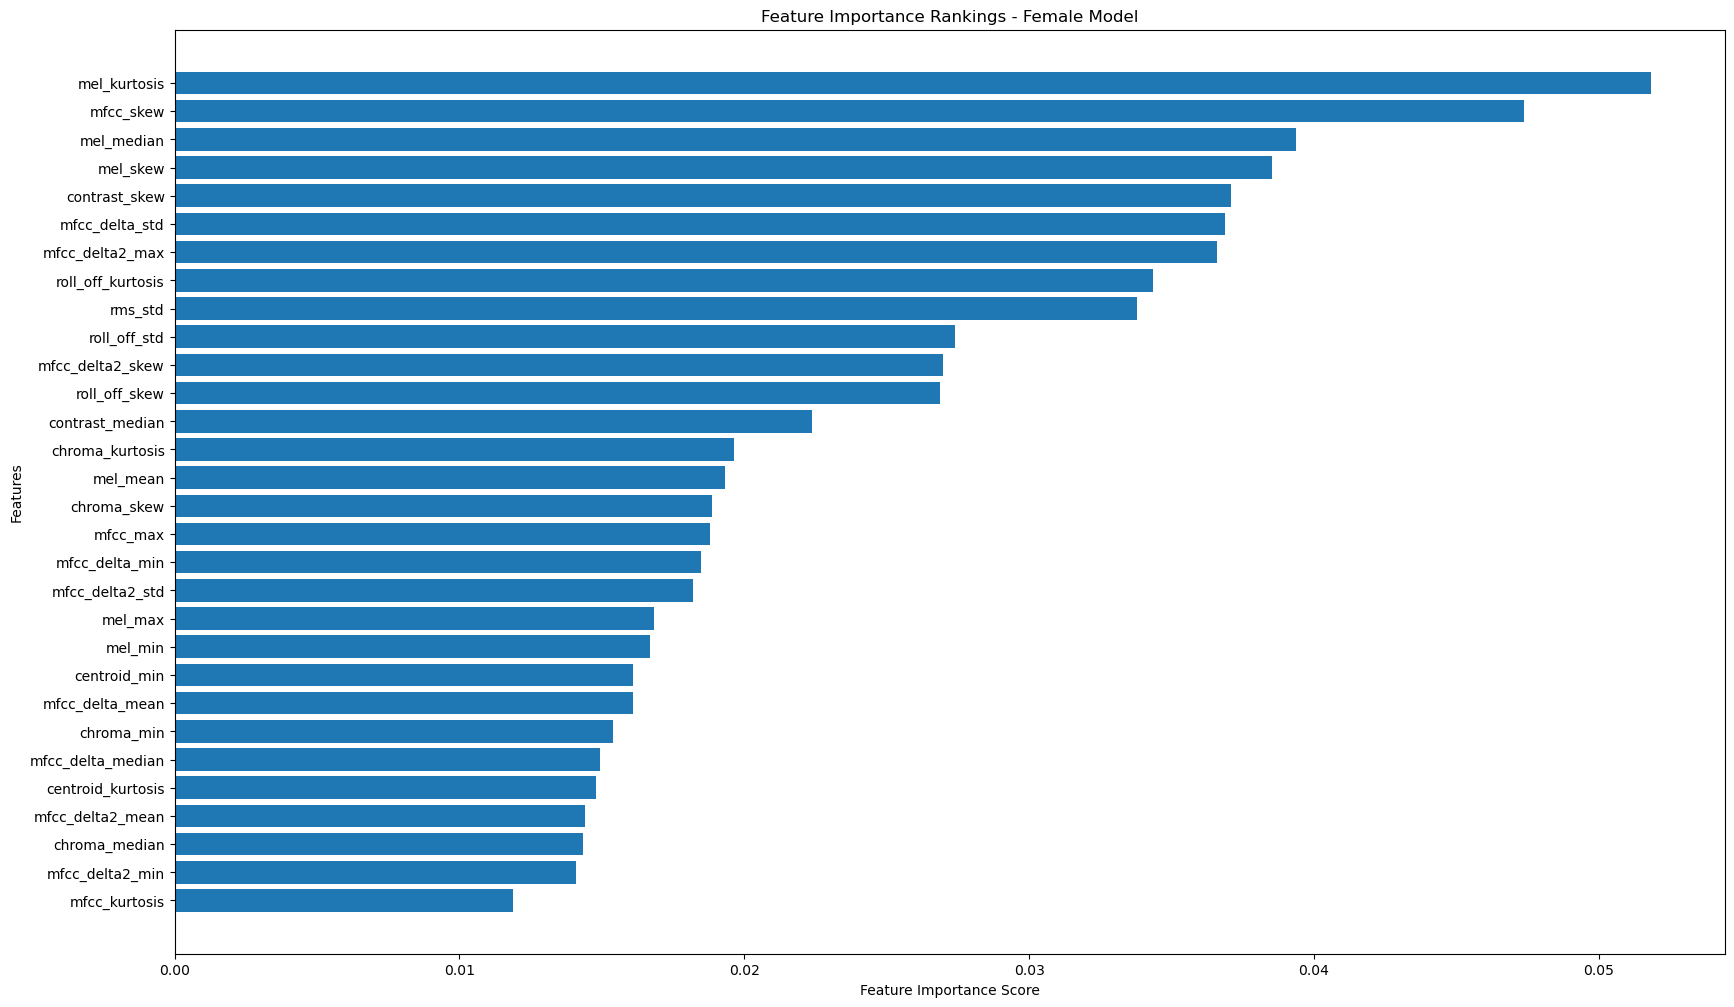

In [8]:
# 'model_male' and 'model_female' are the trained Random Forest models
gb_feature_importances_male = gb_clf_male.feature_importances_
gb_feature_importances_female = gb_clf_female.feature_importances_

# Update this list to match the features used in your current model
gb_feature_names = feature_list

# Creating dictionaries to map feature names to their importances for each model
gb_importances_male = dict(zip(gb_feature_names, gb_feature_importances_male))
gb_importances_female = dict(zip(gb_feature_names, gb_feature_importances_female))

# Function to plot feature importances and return top 30 features
def plot_gb_feature_importances_and_get_top_30(importances, title):
    # Sort features by importance
    gb_sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and scores
    gb_sorted_features = [x[0] for x in gb_sorted_importances]
    gb_sorted_scores = [x[1] for x in gb_sorted_importances]

    # Plot
    plt.figure(figsize=(20, 12))
    plt.barh(gb_sorted_features[:30], gb_sorted_scores[:30])  # Plot only top 30 features
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Return top 30 features
    return gb_sorted_features[:30]

# Get and plot top 20 features for male model
gb_top_30_features_male = plot_gb_feature_importances_and_get_top_30(gb_importances_male, 'Feature Importance Rankings - Male Model')

# Get and plot top 20 features for female model
gb_top_30_features_female = plot_gb_feature_importances_and_get_top_30(gb_importances_female, 'Feature Importance Rankings - Female Model')



Confusion Matrix for Male Model:


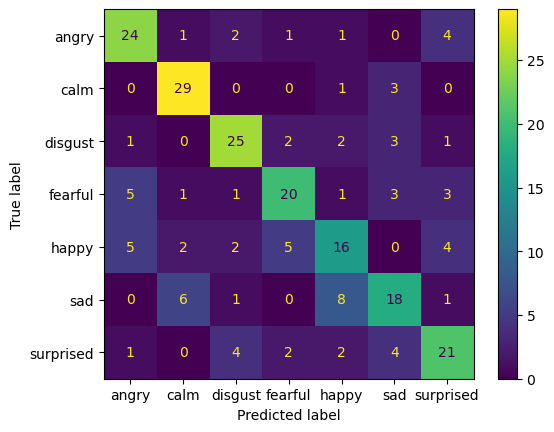

              precision    recall  f1-score   support

       angry       0.67      0.73      0.70        33
        calm       0.74      0.88      0.81        33
     disgust       0.71      0.74      0.72        34
     fearful       0.67      0.59      0.62        34
       happy       0.52      0.47      0.49        34
         sad       0.58      0.53      0.55        34
   surprised       0.62      0.62      0.62        34

    accuracy                           0.65       236
   macro avg       0.64      0.65      0.64       236
weighted avg       0.64      0.65      0.64       236

Training accuracy 1.0000
Testing accuracy 0.6483



Confusion Matrix for Female Model:


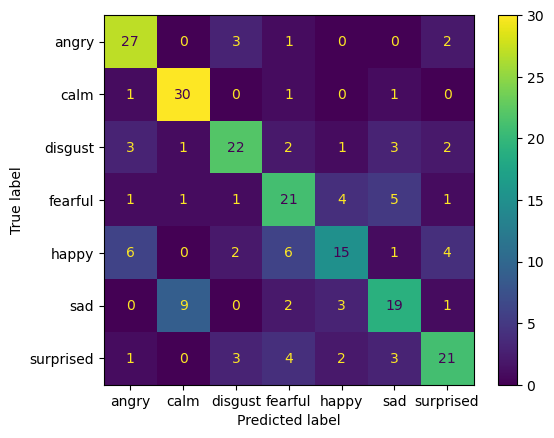

              precision    recall  f1-score   support

       angry       0.69      0.82      0.75        33
        calm       0.73      0.91      0.81        33
     disgust       0.71      0.65      0.68        34
     fearful       0.57      0.62      0.59        34
       happy       0.60      0.44      0.51        34
         sad       0.59      0.56      0.58        34
   surprised       0.68      0.62      0.65        34

    accuracy                           0.66       236
   macro avg       0.65      0.66      0.65       236
weighted avg       0.65      0.66      0.65       236

Training accuracy 1.0000
Testing accuracy 0.6568


In [9]:
# Predict on the test set
y_pred_male = gb_clf_male.predict(X_test_m_sc)
y_pred_female = gb_clf_female.predict(X_test_f_sc)

# Evaluate the models
accuracy_male = accuracy_score(y_test_male, y_pred_male)
accuracy_female = accuracy_score(y_test_female, y_pred_female)

print("\nConfusion Matrix for Male Model:")
cm_m = confusion_matrix(y_test_male, y_pred_male)
cm_m_display = ConfusionMatrixDisplay(confusion_matrix=cm_m, display_labels=gb_clf_male.classes_)
cm_m_display.plot()
plt.show()
print(classification_report(y_test_male, y_pred_male))
print('Training accuracy {:.4f}'.format(gb_clf_male.score(X_train_m_sc, y_train_male)))
print('Testing accuracy {:.4f}'.format(gb_clf_male.score(X_test_m_sc, y_test_male)))
print()
print()
print("\nConfusion Matrix for Female Model:")
cm_f = confusion_matrix(y_test_female, y_pred_female)
cm_f_display = ConfusionMatrixDisplay(confusion_matrix=cm_f, display_labels=gb_clf_female.classes_)
cm_f_display.plot()
plt.show()
print(classification_report(y_test_female, y_pred_female))
print('Training accuracy {:.4f}'.format(gb_clf_female.score(X_train_f_sc, y_train_female)))
print('Testing accuracy {:.4f}'.format(gb_clf_female.score(X_test_f_sc, y_test_female)))

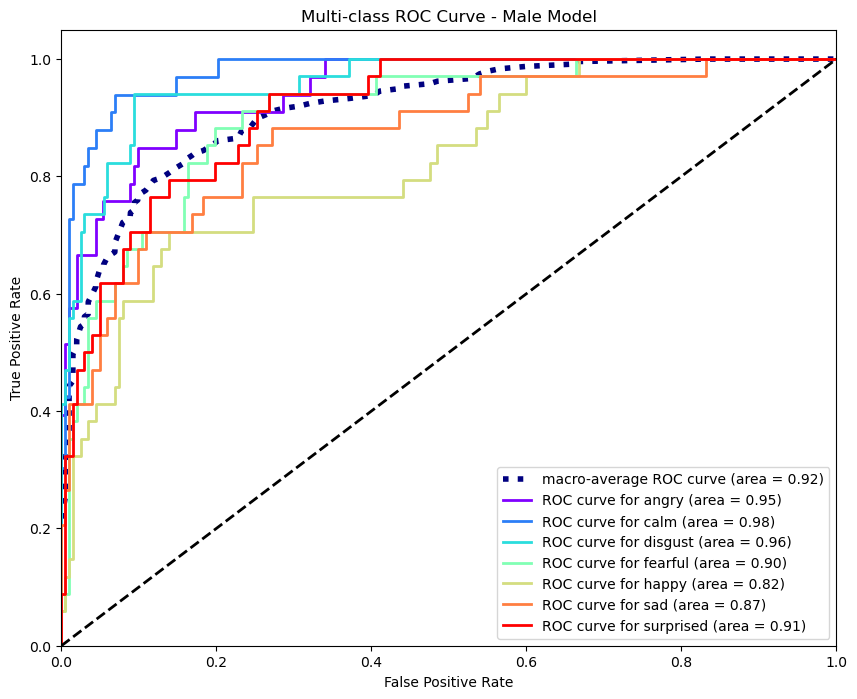

In [10]:
# Define the emotion classes
emotion_classes = gb_clf_male.classes_

# Binarize the labels for the male dataset
y_test_male_binarized = label_binarize(y_test_male, classes=emotion_classes)
n_classes_male = y_test_male_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr_male = dict()
tpr_male = dict()
roc_auc_male = dict()

y_prob = gb_clf_male.predict_proba(X_test_m_sc)

for i in range(n_classes_male):
    fpr_male[i], tpr_male[i], _ = roc_curve(y_test_male_binarized[:, i], y_prob[:, i])
    roc_auc_male[i] = auc(fpr_male[i], tpr_male[i])

# Compute micro-average ROC curve and ROC area
fpr_male["micro"], tpr_male["micro"], _ = roc_curve(y_test_male_binarized.ravel(), y_prob.ravel())
roc_auc_male["micro"] = auc(fpr_male["micro"], tpr_male["micro"])

# Aggregate all false positive rates
all_fpr_male = np.unique(np.concatenate([fpr_male[i] for i in range(n_classes_male)]))

# Interpolate all ROC curves at these points
mean_tpr_male = np.zeros_like(all_fpr_male)
for i in range(n_classes_male):
    mean_tpr_male += np.interp(all_fpr_male, fpr_male[i], tpr_male[i])

# Average it and compute AUC
mean_tpr_male /= n_classes_male

fpr_male["macro"] = all_fpr_male
tpr_male["macro"] = mean_tpr_male
roc_auc_male["macro"] = auc(fpr_male["macro"], tpr_male["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot macro-average ROC curve
plt.plot(fpr_male["macro"], tpr_male["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_male["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes_male)))
for i, color in zip(range(n_classes_male), colors):
    plt.plot(fpr_male[i], tpr_male[i], color=color, lw=2,
             label='ROC curve for {0} (area = {1:0.2f})'.format(emotion_classes[i], roc_auc_male[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Male Model')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Assuming y_test_male and y_pred_male are your true and predicted labels
cm = confusion_matrix(y_test_male, y_pred_male)

# Create a DataFrame from the confusion matrix array
cm_df = pd.DataFrame(cm,
                     index=['Actual: Angry', 'Actual: Calm', 'Actual: Disgust', 'Actual: Fearful', 'Actual: Happy', 'Actual: Sad', 'Actual: Surprised'],
                     columns=['Predicted: Angry', 'Predicted: Calm', 'Predicted: Disgust', 'Predicted: Fearful', 'Predicted: Happy', 'Predicted: Sad', 'Predicted: Surprised'])

# Print the DataFrame
print(cm_df)

                   Predicted: Angry  Predicted: Calm  Predicted: Disgust  \
Actual: Angry                    24                1                   2   
Actual: Calm                      0               29                   0   
Actual: Disgust                   1                0                  25   
Actual: Fearful                   5                1                   1   
Actual: Happy                     5                2                   2   
Actual: Sad                       0                6                   1   
Actual: Surprised                 1                0                   4   

                   Predicted: Fearful  Predicted: Happy  Predicted: Sad  \
Actual: Angry                       1                 1               0   
Actual: Calm                        0                 1               3   
Actual: Disgust                     2                 2               3   
Actual: Fearful                    20                 1               3   
Actual: Happy   

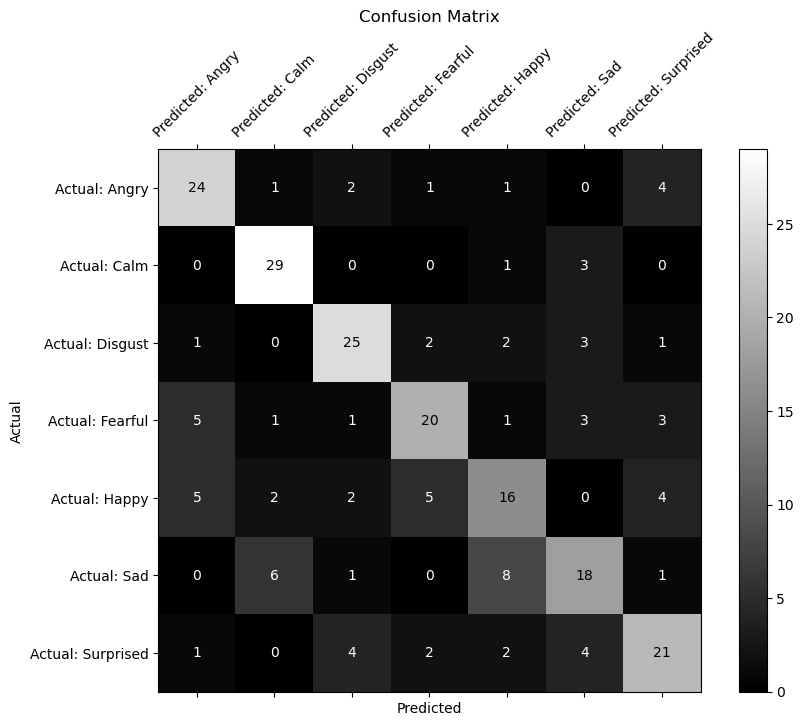

In [13]:
# Assuming y_test_male and y_pred_male are your true and predicted labels
cm = confusion_matrix(y_test_male, y_pred_male)

# Create a DataFrame from the confusion matrix array
cm_df = pd.DataFrame(cm,
                     index=['Actual: Angry', 'Actual: Calm', 'Actual: Disgust', 'Actual: Fearful', 'Actual: Happy', 'Actual: Sad', 'Actual: Surprised'],
                     columns=['Predicted: Angry', 'Predicted: Calm', 'Predicted: Disgust', 'Predicted: Fearful', 'Predicted: Happy', 'Predicted: Sad', 'Predicted: Surprised'])

# Plotting the matrix plot
plt.figure(figsize=(10, 7))
plt.matshow(cm, cmap='gray', fignum=1)
plt.colorbar()
plt.xticks(ticks=range(len(cm_df.columns)), labels=cm_df.columns, rotation=45)
plt.yticks(ticks=range(len(cm_df.index)), labels=cm_df.index)

# Adding annotations with dynamic color
threshold = cm.max() / 2  # Threshold for changing text color
for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black' if cm[i, j] > threshold else 'white'
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color=color)

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
pd.unique(df_male['emotion'])

array(['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'],
      dtype=object)

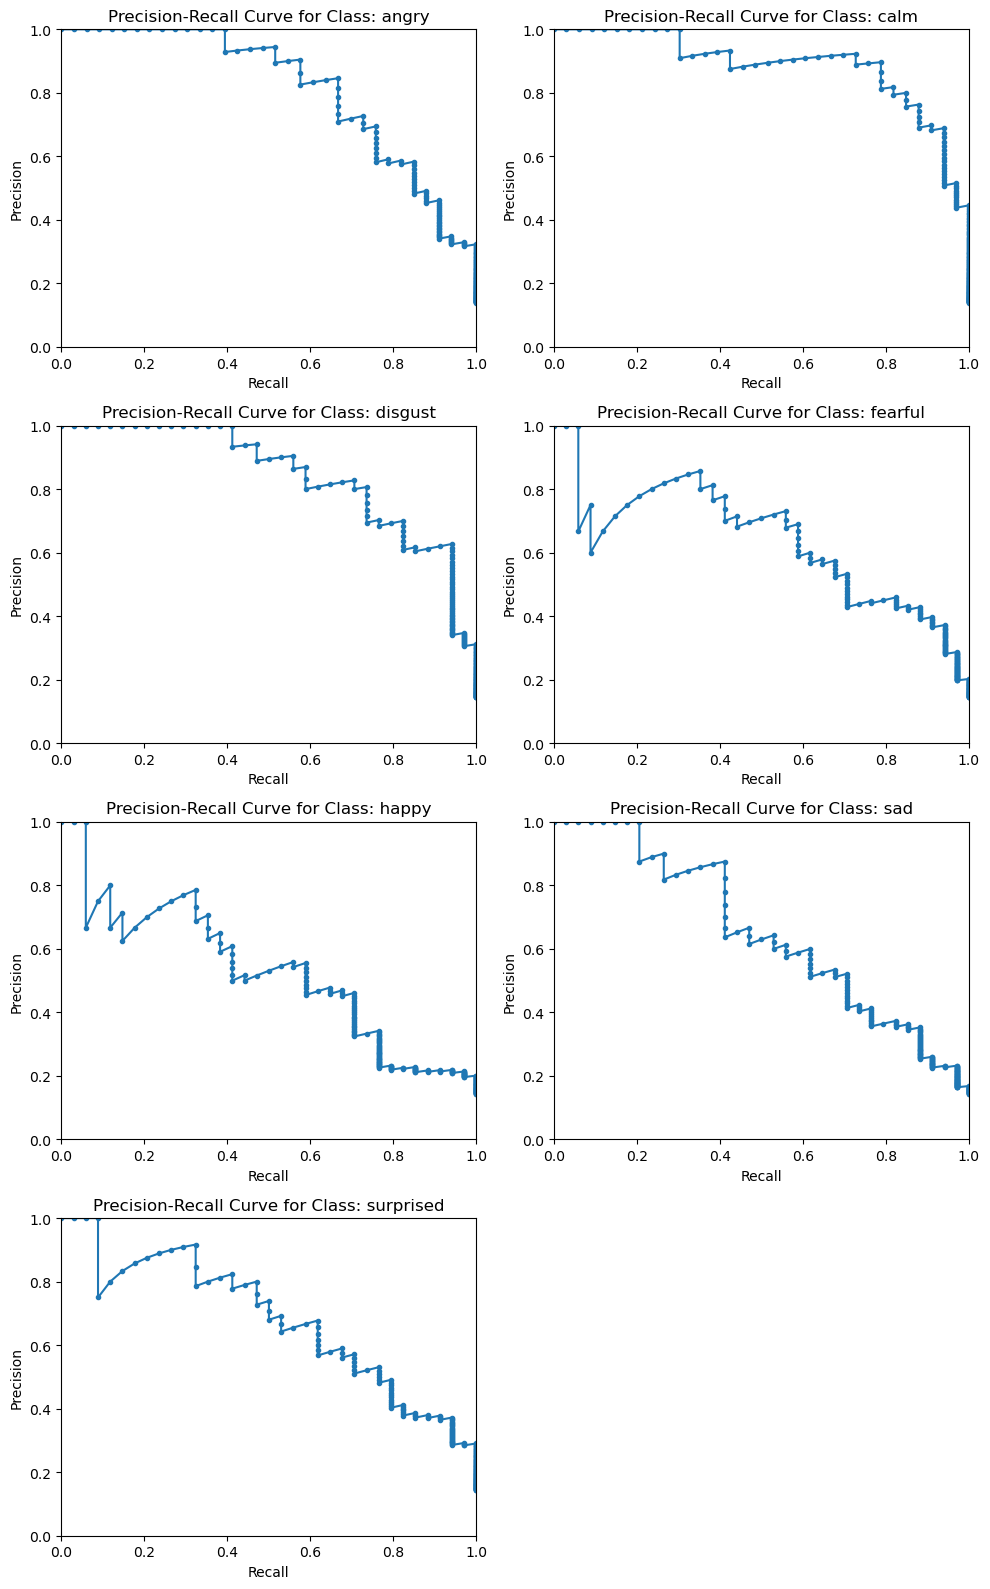

In [15]:
# Assuming 'y_test' is your true labels and 'model' is your trained model
# 'n_classes' is the number of emotion classes
emotion_classes = gb_clf_male.classes_
n_classes = len(emotion_classes)
y_score_m = gb_clf_male.predict_proba(X_test_m_sc)

rows = n_classes // 2 if n_classes % 2 == 0 else (n_classes // 2) + 1

fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, rows * 4))
axes = axes.ravel()

# Hide unused subplots if the number of classes is odd
if n_classes % 2 != 0:
    axes[-1].set_visible(False)

for i in range(n_classes):
    # Convert y_test_male to binary format for the current class
    y_test_binary = np.where(y_test_male == emotion_classes[i], 1, 0)
    
    # Compute precision and recall for each class
    precision, recall, _ = precision_recall_curve(y_test_binary, y_score_m[:, i])
    
    # Plot the precision-recall curve for the class
    axes[i].plot(recall, precision, marker='.')
    axes[i].set_title(f'Precision-Recall Curve for Class: {emotion_classes[i]}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()


After some hyper parameter testing performed better than Random Forest so I will take these feature importance suggestions
with a higher weight for later feature selection. mfcc_delta_median, mfcc_delta2_max, rms_std, and chroma_std performed 
well for male voices. mel_kurtosis, mfcc_skew, mel_median, and mel_skew performed well for female voices.

## Light Gradient Boosting Machine RAVDESS<a id='Light_Gradient_Boosting_Machine_RAVDESS'></a>

*[Contents](#Contents)

In [2]:
data1 = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
# data2 = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
# data3 = pd.read_csv('voice_data_dw_t.csv')     # CREMA-D data
df = pd.DataFrame(data1)
# df_c = pd.DataFrame(data2)
# df_t = pd.DataFrame(data3)
pd.set_option('display.max_columns', None)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-13.750966,208.77170,-651.9564,-5.260116,82.799590,-0.140461,-0.240087,2.491733,33.705196,-17.369028,0.262886,8.115748,1.653565,2.387000,-3.528996,13.174137,-39.414215,-0.135289,10.488796,-2.105011,2.833700,0.395015,0.010886,0.312053,0.300928,0.685030,-0.547113,0.009552,2.615224,4.031165e-18,0.000064,0.065616,3.980199,17.590267,25.992423,75.029004,6.442893,19.913183,16.481322,-0.583810,1.214911,1431.463197,3747.965221,581.068512,1153.185402,752.927915,1.652513,1.915730,2639.395255,5961.914062,999.023438,2325.683594,1357.013887,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-14.013200,203.44556,-647.6516,-5.660081,83.142610,-0.055090,-0.332986,2.484158,33.476566,-16.323960,0.169552,8.183585,1.682235,2.384677,-3.587220,12.778202,-41.543182,-0.156874,10.659009,-2.112810,2.841899,0.372111,0.007602,0.275195,0.309303,0.783203,-0.390124,0.010960,2.218609,3.065071e-18,0.000057,0.074393,3.737703,14.996470,26.730421,75.095133,5.744724,21.058785,16.718861,-0.121057,2.233361,1428.133969,3787.006232,598.127794,1266.335723,719.014344,1.745676,2.597192,2754.882812,5918.945312,1020.507812,2578.125000,1289.368157,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-13.286643,212.63199,-603.8165,-5.457789,80.696570,-0.069167,-0.244607,2.352925,30.742325,-17.451830,0.207793,7.844898,1.603152,2.356841,-3.394885,11.864449,-39.883760,-0.110547,10.175233,-2.084090,2.802068,0.365138,0.006354,0.270417,0.299614,0.818134,-0.119496,0.015128,2.815824,4.134282e-18,0.000086,0.100440,3.830205,16.569090,26.321257,79.730935,4.494108,20.461424,16.544478,-0.328206,1.317845,1573.538319,4867.721737,537.361416,1173.576030,1054.731555,1.894945,2.580431,2852.647569,6262.695312,945.312500,2529.785156,1511.726106,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-13.380160,214.31924,-625.3130,-5.920652,81.306900,-0.068310,-0.379298,2.378634,32.634373,-17.722158,0.145714,7.996109,1.636472,2.379754,-3.510836,13.831413,-42.689724,-0.203858,10.426331,-2.097874,2.825182,0.399993,0.012884,0.301367,0.299288,0.811549,-0.325152,0.014019,3.281666,4.709254e-18,0.000072,0.097377,3.622848,14.702682,26.110333,78.056904,4.348983,20.056309,16.610803,-0.369971,1.573650,1564.442378,4695.050625,657.966547,1252.034920,1035.142571,1.732141,1.991167,2855.356070,6241.210938,923.828125,2567.382812,1535.589595,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-14.227764,217.13522,-693.7061,-4.584452,90.910904,-0.134584,-0

In [3]:
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [4]:
df.columns

Index(['filename', 'modality', 'vocal_channel', 'emotion', 'voice_intensity',
       'statement', 'statement_repetition', 'actor_gender', 'mfcc_mean',
       'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std', 'mfcc_skew',
       'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max', 'mfcc_delta_min',
       'mfcc_delta_median', 'mfcc_delta_std', 'mfcc_delta_skew',
       'mfcc_delta_kurtosis', 'mfcc_delta2_mean', 'mfcc_delta2_max',
       'mfcc_delta2_min', 'mfcc_delta2_median', 'mfcc_delta2_std',
       'mfcc_delta2_skew', 'mfcc_delta2_kurtosis', 'chroma_mean', 'chroma_min',
       'chroma_median', 'chroma_std', 'chroma_skew', 'chroma_kurtosis',
       'mel_mean', 'mel_max', 'mel_min', 'mel_median', 'mel_std', 'mel_skew',
       'mel_kurtosis', 'contrast_mean', 'contrast_max', 'contrast_min',
       'contrast_median', 'contrast_std', 'contrast_skew', 'contrast_kurtosis',
       'centroid_mean', 'centroid_max', 'centroid_min', 'centroid_median',
       'centroid_std', 'centroid_skew', '

In [4]:
feature_list = df.columns[8:]

In [5]:
# Dividing dataset into genders
df_male = df[df['actor_gender'] == 1]
df_female = df[df['actor_gender'] == 2]

# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

# Features and labels for male dataset
X_male = df_male[feature_list]
y_male = df_male['emotion'].values

# Features and labels for female dataset
X_female = df_female[feature_list]
y_female = df_female['emotion'].values

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.35, random_state=42, shuffle=True, stratify=y_male)

# Splitting the female dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.35, random_state=42, shuffle=True, stratify=y_female)

# Initialize scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_m_sc = pd.DataFrame(scaler_male.fit_transform(X_train_male), columns=X_train_male.columns)
X_test_m_sc = pd.DataFrame(scaler_male.transform(X_test_male), columns=X_test_male.columns)

# Scale the female datasets
X_train_f_sc = pd.DataFrame(scaler_female.fit_transform(X_train_female), columns=X_train_female.columns)
X_test_f_sc = pd.DataFrame(scaler_female.transform(X_test_female), columns=X_test_female.columns)

print("Male Dataset:", X_train_m_sc.shape, X_test_m_sc.shape, y_train_male.shape, y_test_male.shape)
print("Female Dataset:", X_train_f_sc.shape, X_test_f_sc.shape, y_train_female.shape, y_test_female.shape)

Male Dataset: (436, 69) (236, 69) (436,) (236,)
Female Dataset: (436, 69) (236, 69) (436,) (236,)


In [6]:
# # Define the parameter grid to sample from
# param_grid_m = {
#     'num_leaves': [3, 7, 15, 31, 63],
#     'max_depth': [5, 8, 10, 15, 20, -1],
#     'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 500, 1000],
#     'min_child_weight': [0.001, 0.01, 0.1, 1],
#     'min_child_samples': [5, 10, 20, 30],
#     'reg_alpha': [0, 0.1, 0.5, 1],
#     'reg_lambda': [0, 0.1, 0.5, 1],
#     'min_gain_to_split': [0.0, 0.1, 0.2, 0.5],
#     'min_data_in_leaf': [3, 10, 20, 40],
#     'min_sum_hessian_in_leaf': [1, 3, 5, 10]
# }

# # Initialize the LGBMClassifier
# lgbm_male = lgb.LGBMClassifier(random_state=42, n_jobs=-1, importance_type='split', verbose=-1)

# # Setup RandomizedSearchCV
# random_search_m = RandomizedSearchCV(lgbm_male, param_distributions=param_grid_m, 
#                                    n_iter=100, scoring='neg_log_loss', 
#                                    cv=5, verbose=1, random_state=42, n_jobs=-1)

# # Fit RandomizedSearchCV
# random_search_m.fit(X_train_m_sc, y_train_male, 
#                   eval_set=[(X_test_m_sc, y_test_male), (X_train_m_sc, y_train_male)], 
#                   eval_metric='logloss')

# # Best parameters and model
# best_params_m = random_search_m.best_params_
# best_model_m = random_search_m.best_estimator_

# print("Best Parameters:", best_params_m)


# Initialize the Light Gradient Boosting Machine and train the model
# best testing accuracy: 0.6741
# lgbm_male = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-7, learning_rate=0.05, n_estimators=500, 
#                                min_child_weight=0.001, min_child_samples=5, subsample=1.0, subsample_freq=0, 
#                                colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=42, n_jobs=-1, 
#                                importance_type='split')

lgbm_male = lgb.LGBMClassifier(reg_lambda=1, reg_alpha=0.5, num_leaves=7, n_estimators=1000, 
                               min_sum_hessian_in_leaf=1, min_gain_to_split=0.2, min_data_in_leaf=20, 
                               min_child_weight=0.001, min_child_samples=5, max_depth=15, 
                               learning_rate=0.005, verbose=-1)

lgbm_male.fit(X_train_m_sc, y_train_male, eval_set=[(X_test_m_sc, y_test_male), (X_train_m_sc, y_train_male)], 
              eval_metric='logloss')

LGBMClassifier(learning_rate=0.005, max_depth=15, min_child_samples=5,
               min_data_in_leaf=20, min_gain_to_split=0.2,
               min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=7,
               reg_alpha=0.5, reg_lambda=1, verbose=-1)

In [7]:
# # Define the parameter grid to sample from
# param_grid_f = {
#     'num_leaves': [3, 7, 15, 31, 63],
#     'max_depth': [5, 8, 10, 15, 20, -1],
#     'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 500, 1000],
#     'min_child_weight': [0.001, 0.01, 0.1, 1],
#     'min_child_samples': [5, 10, 20, 30],
#     'reg_alpha': [0, 0.1, 0.5, 1],
#     'reg_lambda': [0, 0.1, 0.5, 1],
#     'min_gain_to_split': [0.0, 0.1, 0.2, 0.5],
#     'min_data_in_leaf': [3, 10, 20, 40],
#     'min_sum_hessian_in_leaf': [1, 3, 5, 10]
# }

# # Initialize the LGBMClassifier
# lgbm_female = lgb.LGBMClassifier(random_state=42, n_jobs=-1, importance_type='split', verbose=-1)

# # Setup RandomizedSearchCV
# random_search_f = RandomizedSearchCV(lgbm_female, param_distributions=param_grid_f, 
#                                    n_iter=100, scoring='neg_log_loss', 
#                                    cv=5, verbose=1, random_state=42, n_jobs=-1)

# # Fit RandomizedSearchCV
# random_search_f.fit(X_train_f_sc, y_train_female, 
#                   eval_set=[(X_test_f_sc, y_test_female), (X_train_f_sc, y_train_female)], 
#                   eval_metric='logloss')

# # Best parameters and model
# best_params_f = random_search_f.best_params_
# best_model_f = random_search_f.best_estimator_

# print("Best Parameters:", best_params_f)
# Fitting 5 folds for each of 100 candidates, totalling 500 fits
# Best Parameters: {'reg_lambda': 1, 'reg_alpha': 0.1, 'num_leaves': 15, 'n_estimators': 1000, 
#                   'min_sum_hessian_in_leaf': 1, 'min_gain_to_split': 0.2, 'min_data_in_leaf': 20, 
#                   'min_child_weight': 0.1, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.01}


# Initialize the Light Gradient Boosting Machine and train the model
# best testing accuracy: 0.6931
# lgbm_female = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-7, learning_rate=0.05, n_estimators=500, 
#                                  min_child_weight=0.001, min_child_samples=5, subsample=1.0, subsample_freq=0, 
#                                  colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=42, n_jobs=-1, 
#                                  importance_type='split')

lgbm_female = lgb.LGBMClassifier(reg_lambda=1, reg_alpha=0.1, num_leaves=15, n_estimators=1000, min_sum_hessian_in_leaf=1, 
                                 min_gain_to_split=0.2, min_data_in_leaf=20, min_child_weight=0.1, min_child_samples=20, 
                                 max_depth=20, learning_rate=0.01, verbose=-1)

lgbm_female.fit(X_train_f_sc, y_train_female, eval_set=[(X_test_f_sc, y_test_female), (X_train_f_sc, y_train_female)], 
              eval_metric='logloss')

LGBMClassifier(learning_rate=0.01, max_depth=20, min_child_weight=0.1,
               min_data_in_leaf=20, min_gain_to_split=0.2,
               min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=15,
               reg_alpha=0.1, reg_lambda=1, verbose=-1)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

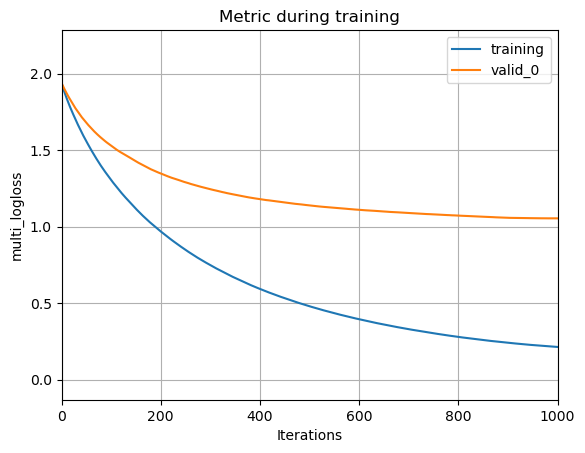

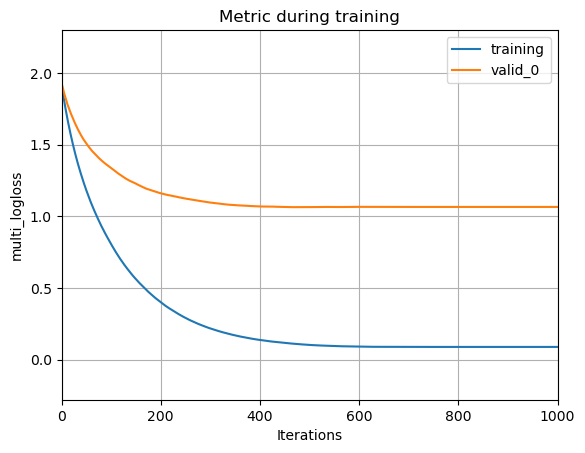

In [8]:
lgb.plot_metric(lgbm_male)
lgb.plot_metric(lgbm_female)

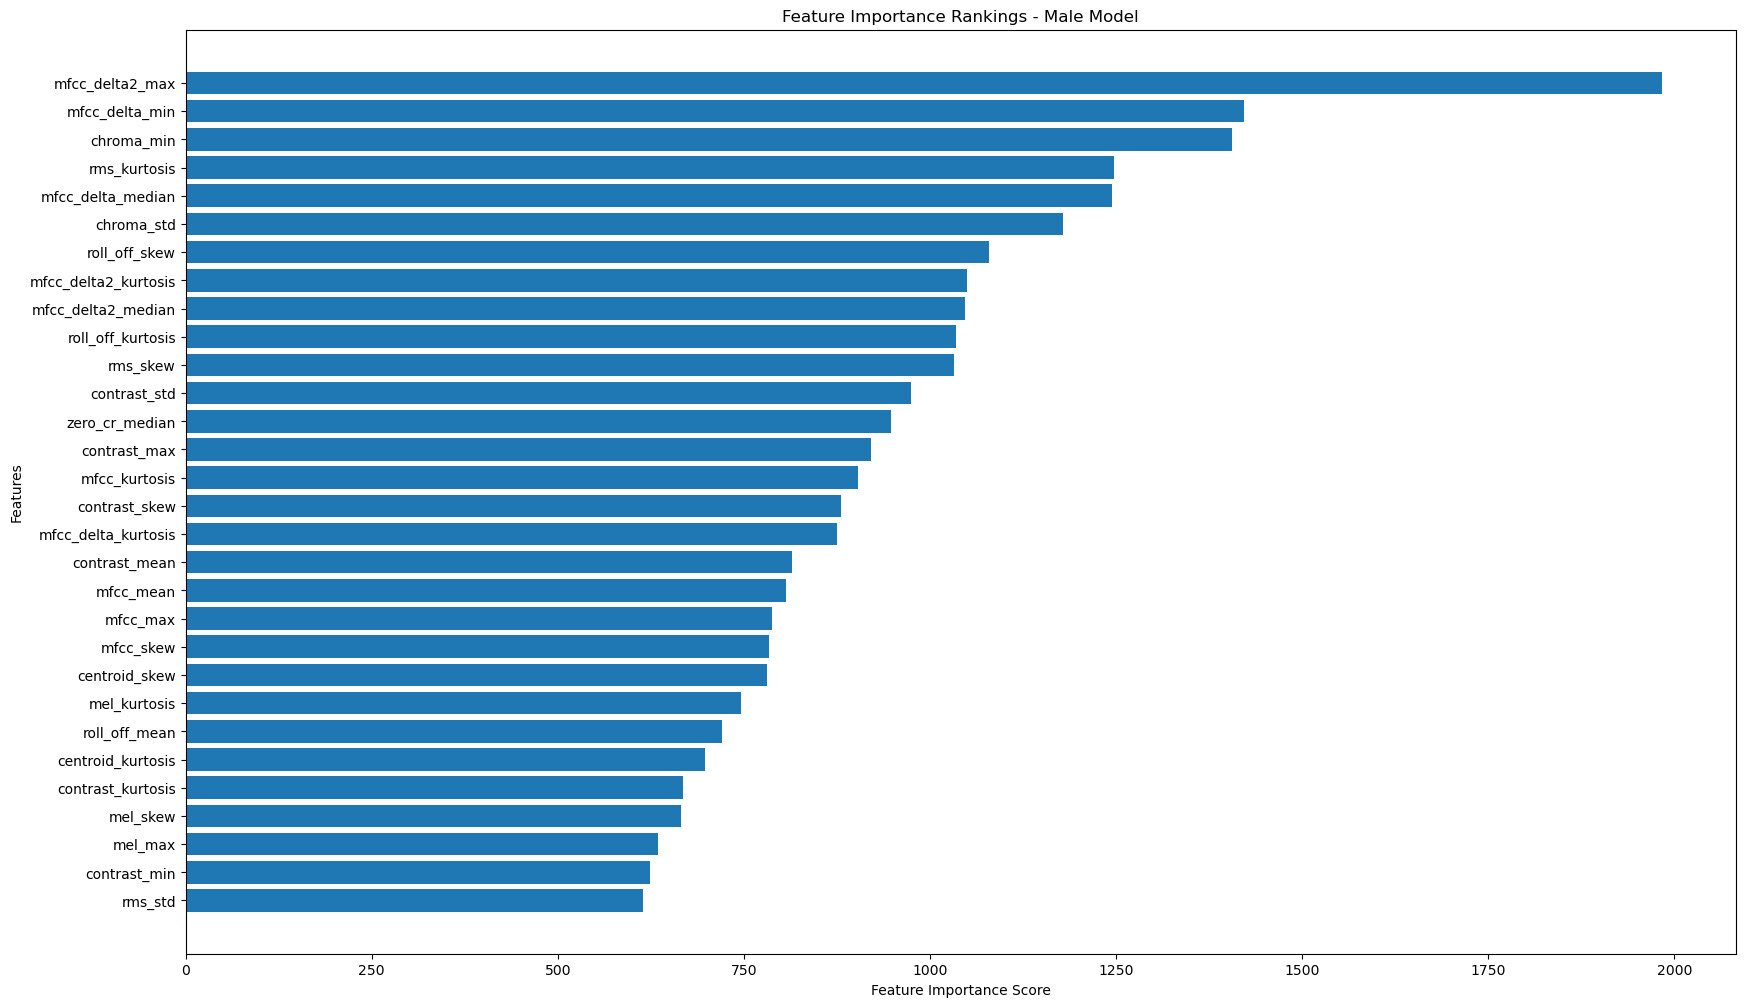

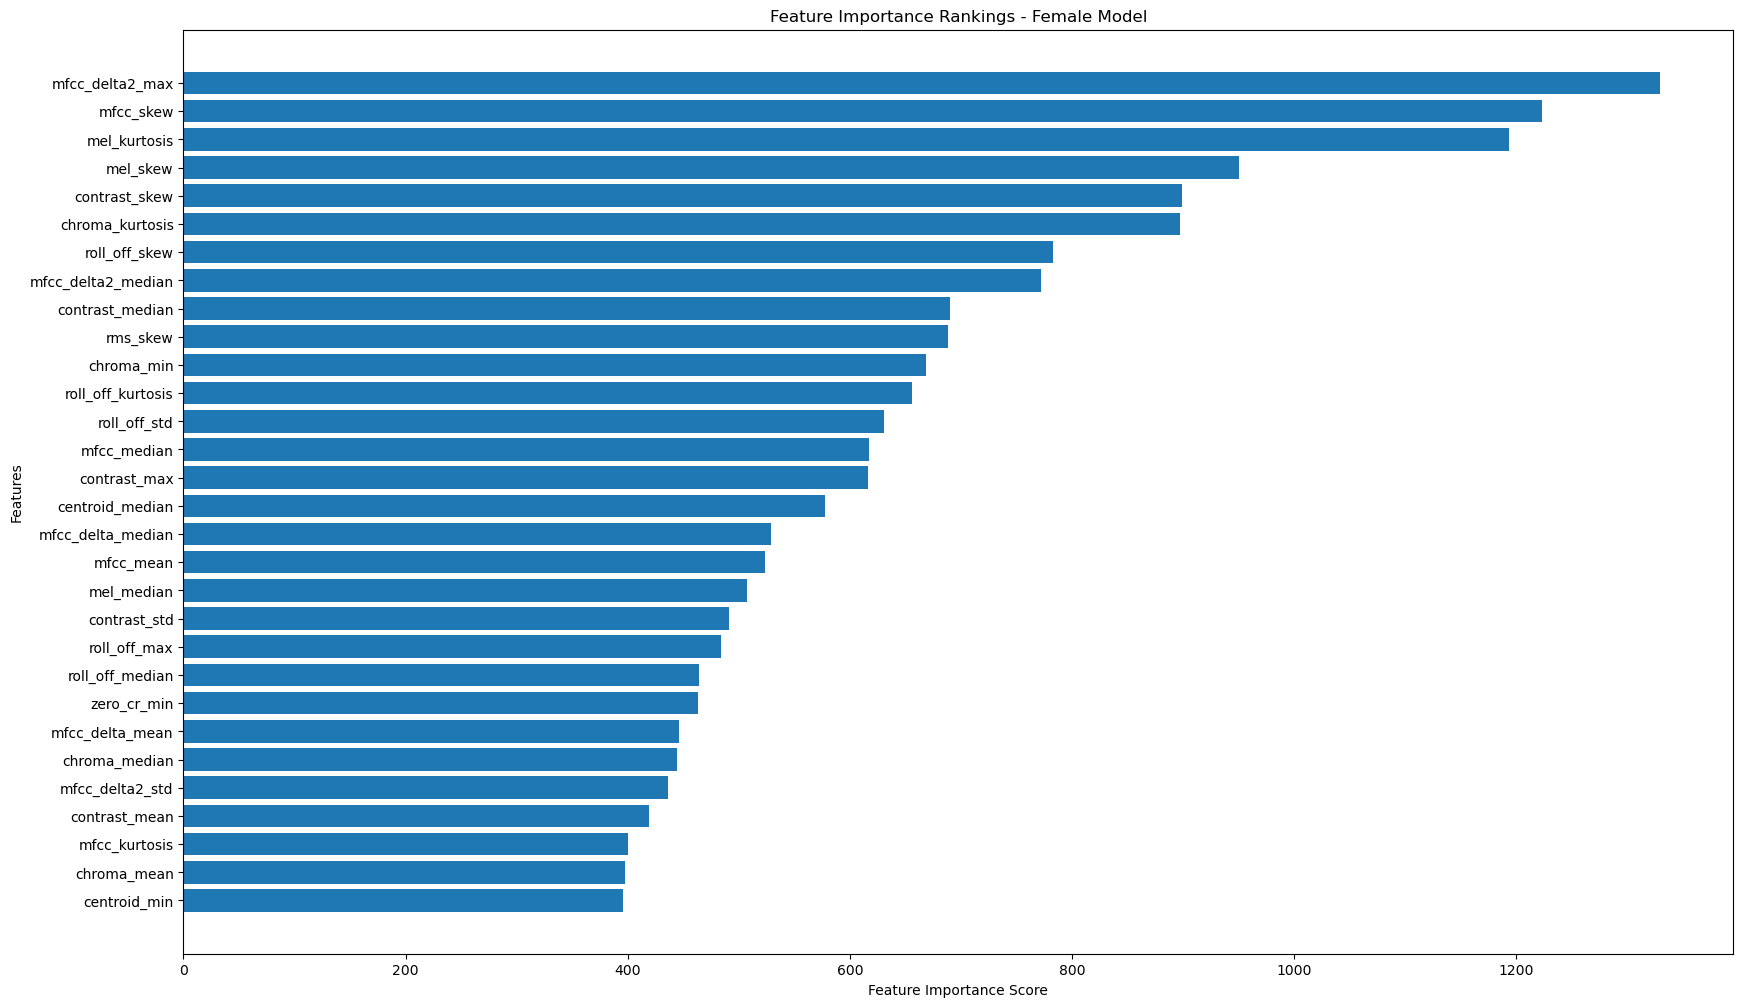

In [9]:
# 'model_male' and 'model_female' are the trained Random Forest models
lgbm_feature_importances_male = lgbm_male.feature_importances_
lgbm_feature_importances_female = lgbm_female.feature_importances_

# Update this list to match the features used in your current model
lgbm_feature_names = feature_list

# Creating dictionaries to map feature names to their importances for each model
lgbm_importances_male = dict(zip(lgbm_feature_names, lgbm_feature_importances_male))
lgbm_importances_female = dict(zip(lgbm_feature_names, lgbm_feature_importances_female))

# Function to plot feature importances and return top 30 features
def plot_lgbm_feature_importances_and_get_top_30(importances, title):
    # Sort features by importance
    lgbm_sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and scores
    lgbm_sorted_features = [x[0] for x in lgbm_sorted_importances]
    lgbm_sorted_scores = [x[1] for x in lgbm_sorted_importances]

    # Plot
    plt.figure(figsize=(20, 12))
    plt.barh(lgbm_sorted_features[:30], lgbm_sorted_scores[:30])  # Plot only top 30 features
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Return top 30 features
    return lgbm_sorted_features[:30]

# Get and plot top 30 features for male model
lgbm_top_30_features_male = plot_lgbm_feature_importances_and_get_top_30(lgbm_importances_male, 'Feature Importance Rankings - Male Model')

# Get and plot top 20 features for female model
lgbm_top_30_features_female = plot_lgbm_feature_importances_and_get_top_30(lgbm_importances_female, 'Feature Importance Rankings - Female Model')



Confusion Matrix for Male Model:


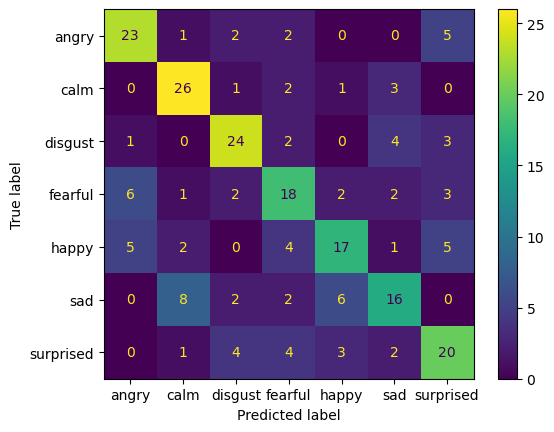

              precision    recall  f1-score   support

       angry       0.66      0.70      0.68        33
        calm       0.67      0.79      0.72        33
     disgust       0.69      0.71      0.70        34
     fearful       0.53      0.53      0.53        34
       happy       0.59      0.50      0.54        34
         sad       0.57      0.47      0.52        34
   surprised       0.56      0.59      0.57        34

    accuracy                           0.61       236
   macro avg       0.61      0.61      0.61       236
weighted avg       0.61      0.61      0.61       236

Training accuracy 1.0000
Testing accuracy 0.6102



Confusion Matrix for Female Model:


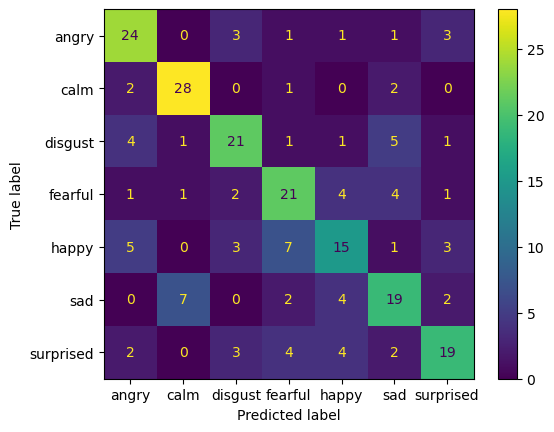

              precision    recall  f1-score   support

       angry       0.63      0.73      0.68        33
        calm       0.76      0.85      0.80        33
     disgust       0.66      0.62      0.64        34
     fearful       0.57      0.62      0.59        34
       happy       0.52      0.44      0.48        34
         sad       0.56      0.56      0.56        34
   surprised       0.66      0.56      0.60        34

    accuracy                           0.62       236
   macro avg       0.62      0.62      0.62       236
weighted avg       0.62      0.62      0.62       236

Training accuracy 1.0000
Testing accuracy 0.6229


In [10]:
# Predict on the test set
y_pred_male = lgbm_male.predict(X_test_m_sc)
y_pred_female = lgbm_female.predict(X_test_f_sc)

# Evaluate the models
accuracy_male = accuracy_score(y_test_male, y_pred_male)
accuracy_female = accuracy_score(y_test_female, y_pred_female)

print("\nConfusion Matrix for Male Model:")
cm_m = confusion_matrix(y_test_male, y_pred_male)
cm_m_display = ConfusionMatrixDisplay(confusion_matrix=cm_m, display_labels=lgbm_male.classes_)
cm_m_display.plot()
plt.show()
print(classification_report(y_test_male, y_pred_male))
print('Training accuracy {:.4f}'.format(lgbm_male.score(X_train_m_sc, y_train_male)))
print('Testing accuracy {:.4f}'.format(lgbm_male.score(X_test_m_sc, y_test_male)))
print()
print()
print("\nConfusion Matrix for Female Model:")
cm_f = confusion_matrix(y_test_female, y_pred_female)
cm_f_display = ConfusionMatrixDisplay(confusion_matrix=cm_f, display_labels=lgbm_female.classes_)
cm_f_display.plot()
plt.show()
print(classification_report(y_test_female, y_pred_female))
print('Training accuracy {:.4f}'.format(lgbm_female.score(X_train_f_sc, y_train_female)))
print('Testing accuracy {:.4f}'.format(lgbm_female.score(X_test_f_sc, y_test_female)))

<Axes: title={'center': 'female feature importance'}, xlabel='Feature importance', ylabel='Features'>

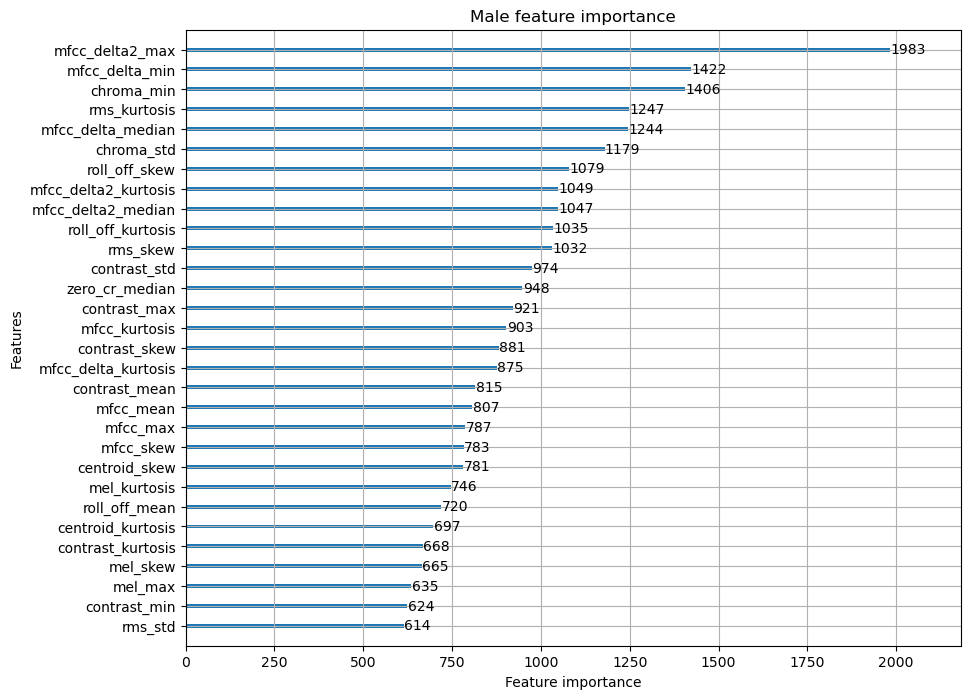

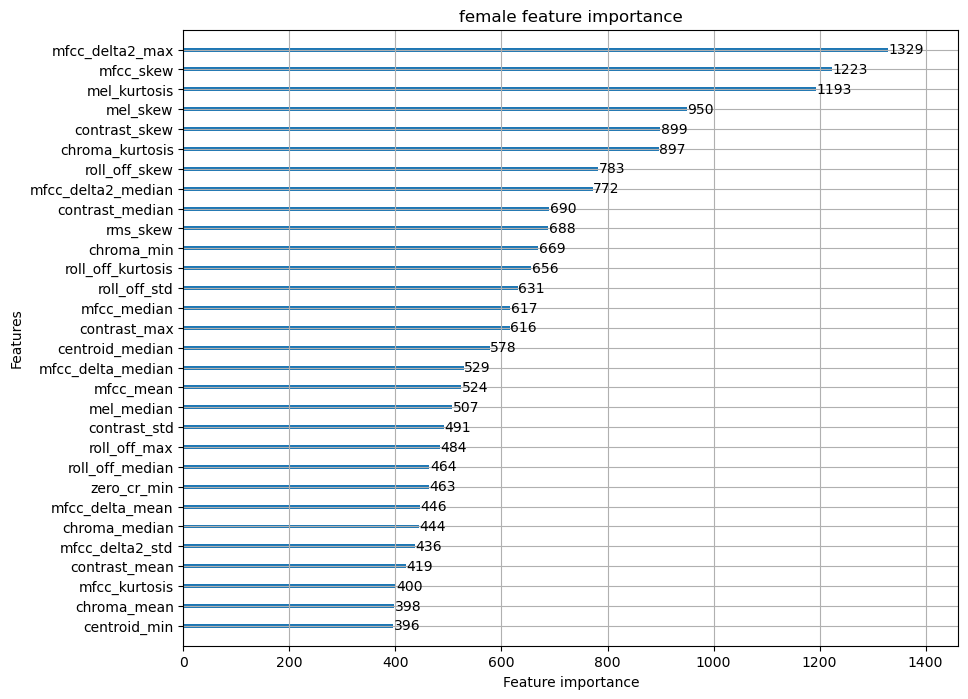

In [11]:
lgb.plot_importance(lgbm_male, max_num_features=30, title='Male feature importance', figsize=(10,8))
lgb.plot_importance(lgbm_female, max_num_features=30, title='female feature importance', figsize=(10,8))

<Axes: >

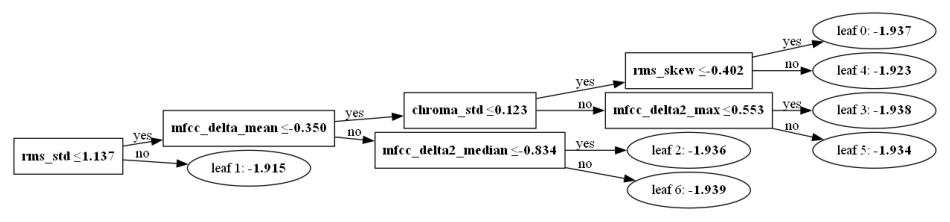

In [12]:
lgb.plot_tree(lgbm_male,figsize=(12,10))

<Axes: >

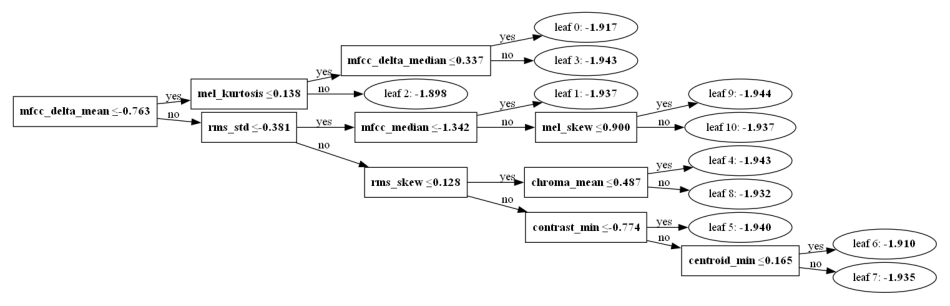

In [13]:
lgb.plot_tree(lgbm_female,figsize=(12,10))

Since Gradient Boosting performed well I wanted to try some further testing with Light Gradient Boosting but
did not see a significant improvement even when mixing in some RandomizedSearchCV hyper-parameter variations. 
mfcc_delta2_max, mfcc_delta_min, and chroma_min were high performers for male voices. mfcc_delta2_max, mfcc_skew, 
and mel_kurtosis were high performers for female voices.

## Conclusion

*[Contents](#Contents)

This testing models helped with identifying some good features so we can narrow down the 70+ that were extracted 
in the dataframe creation process. I will use these features going forward to help tune a different model 
in hopes of getting higher performance. Male voice features that performed well for these 3 models were: mel_median, 
mfcc_delta_median, mfcc_delta2_max, mfcc_delta2_min, mfcc_delta_min, chroma_min, mfcc_std, rms_std, chroma_std, and rms_std. 
For female voices, the features the performed well with these models were more consistent: mel_median, mel_skew, 
mfcc_delta2_max, roll_off_kertosis, mfcc_skew, and mel_kurtosis. I'm interested to see if the important features 
for the female voices will have better resutls.